In [5]:
# packages - probably not all of them required
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib.colors import LogNorm
import numpy as np
import xarray as xr
import intake
from easygems import healpix as egh
import warnings
import healpy as hp
import cmocean

In [2]:
#data import and processing
current_location = "online"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]

icon = cat["icon_d3hp003"](zoom=7).to_dask() 

ifs = cat["ifs_tco3999-ng5_rcbmf_cf"](zoom=7).to_dask() 

nicam = cat["nicam_gl11"](zoom=7).to_dask() 

scream=cat["scream-dkrz"](zoom=7).to_dask()
scream['pr']=scream['pr']*1000 # precip data in m 

um=cat["um_glm_n2560_RAL3p3"](zoom=7)(time='PT1H').to_dask()
um['pr']=um['pr']+um['prs'] # precipitation data split into liquid and solid

casesm=cat["casesm2_10km_nocumulus"](time='PT3H',zoom=7).to_dask()

era5=cat["ERA5"](zoom=7).to_dask()
era5['pr']=era5['tp']*30400 # data given in m per day so converted to mm per month

jra=cat["JRA3Q"](zoom=7).to_dask()
jra['pr']=jra['mtpr'] #naming

merra=cat["MERRA2"](zoom=7).to_dask()
merra['pr']=merra['prectot'] #naming

In [3]:
dataset_list = [era5, icon, ifs, nicam, scream, um, casesm, jra, merra]
titles = ["ERA5", "ICON", "IFS", "NICAM", "Scream", "UM", "CAS-ESM", "JRA", "MERRA"]

def precip_map(region="greenland"):
    " Plots precipitation maps for 6 models and 3 reanalysis assuming models imported with those names"
    " region = greenland or antarctica "
    def compute_total_precip(ds, title):
        if title.lower() == "era5":
            return ds['pr'].sel(time=slice("2020-03", "2021-02")).sum(dim='time')
        elif title.lower() == "scream":
            t = ds['pr'].sel(time=slice("2019-09", "2020-08"))
            return (t * 3600).sum(dim='time')
        else:
            pr = ds['pr'].sel(time=slice("2020-03", "2021-02"))
            dt = pr['time'].diff('time') / np.timedelta64(1, 's')
            dt = np.append(dt, dt[-1])
            dt_da = xr.DataArray(dt, coords={"time": pr.time}, dims="time")
            return (pr * dt_da).sum(dim='time')

    if region.lower() == "greenland":
        projection = ccrs.Stereographic(central_latitude=70, central_longitude=-42)
        extent = [-80, -10, 58, 85]
        norm = LogNorm(vmin=30, vmax=7000)
    elif region.lower() == "antarctica":
        projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0)
        extent = [-180, 180, -90, -64]
        norm = LogNorm(vmin=10, vmax=2000)
    else:
        raise ValueError("region must be 'greenland' or 'antarctica'")

    cmap = plt.get_cmap("YlGnBu").copy()
    cmap.set_bad("white")
    #norm = LogNorm(vmin=vmin, vmax=vmax)

    n = len(dataset_list)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4.5*nrows),
                            subplot_kw={'projection': projection},
                            constrained_layout=True)
    axs = axs.flatten()

    for i, (ds, title) in enumerate(zip(dataset_list, titles)):
        ax = axs[i]
        ax.set_extent(extent, crs=ccrs.PlateCarree())

        mean_pr = compute_total_precip(ds, title)

        im = egh.healpix_show(mean_pr.where(mean_pr > 0), ax=ax, cmap=cmap, norm=norm)
        ax.set_title(title, fontsize=10)
        ax.add_feature(cf.COASTLINE, linewidth=0.4)
        ax.add_feature(cf.BORDERS, linewidth=0.3)
        ax.gridlines(draw_labels=False, linewidth=0.2, color='gray', alpha=0.4, linestyle='--')

    for j in range(i + 1, len(axs)):
        axs[j].remove()

    cbar = fig.colorbar(im, ax=axs[:n], orientation="horizontal", pad=0.05, aspect=40)
    cbar.set_label("Total Yearly Precipitation [mm]")

    plt.show()

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 62 times more chunks
  return self.array[key]
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10

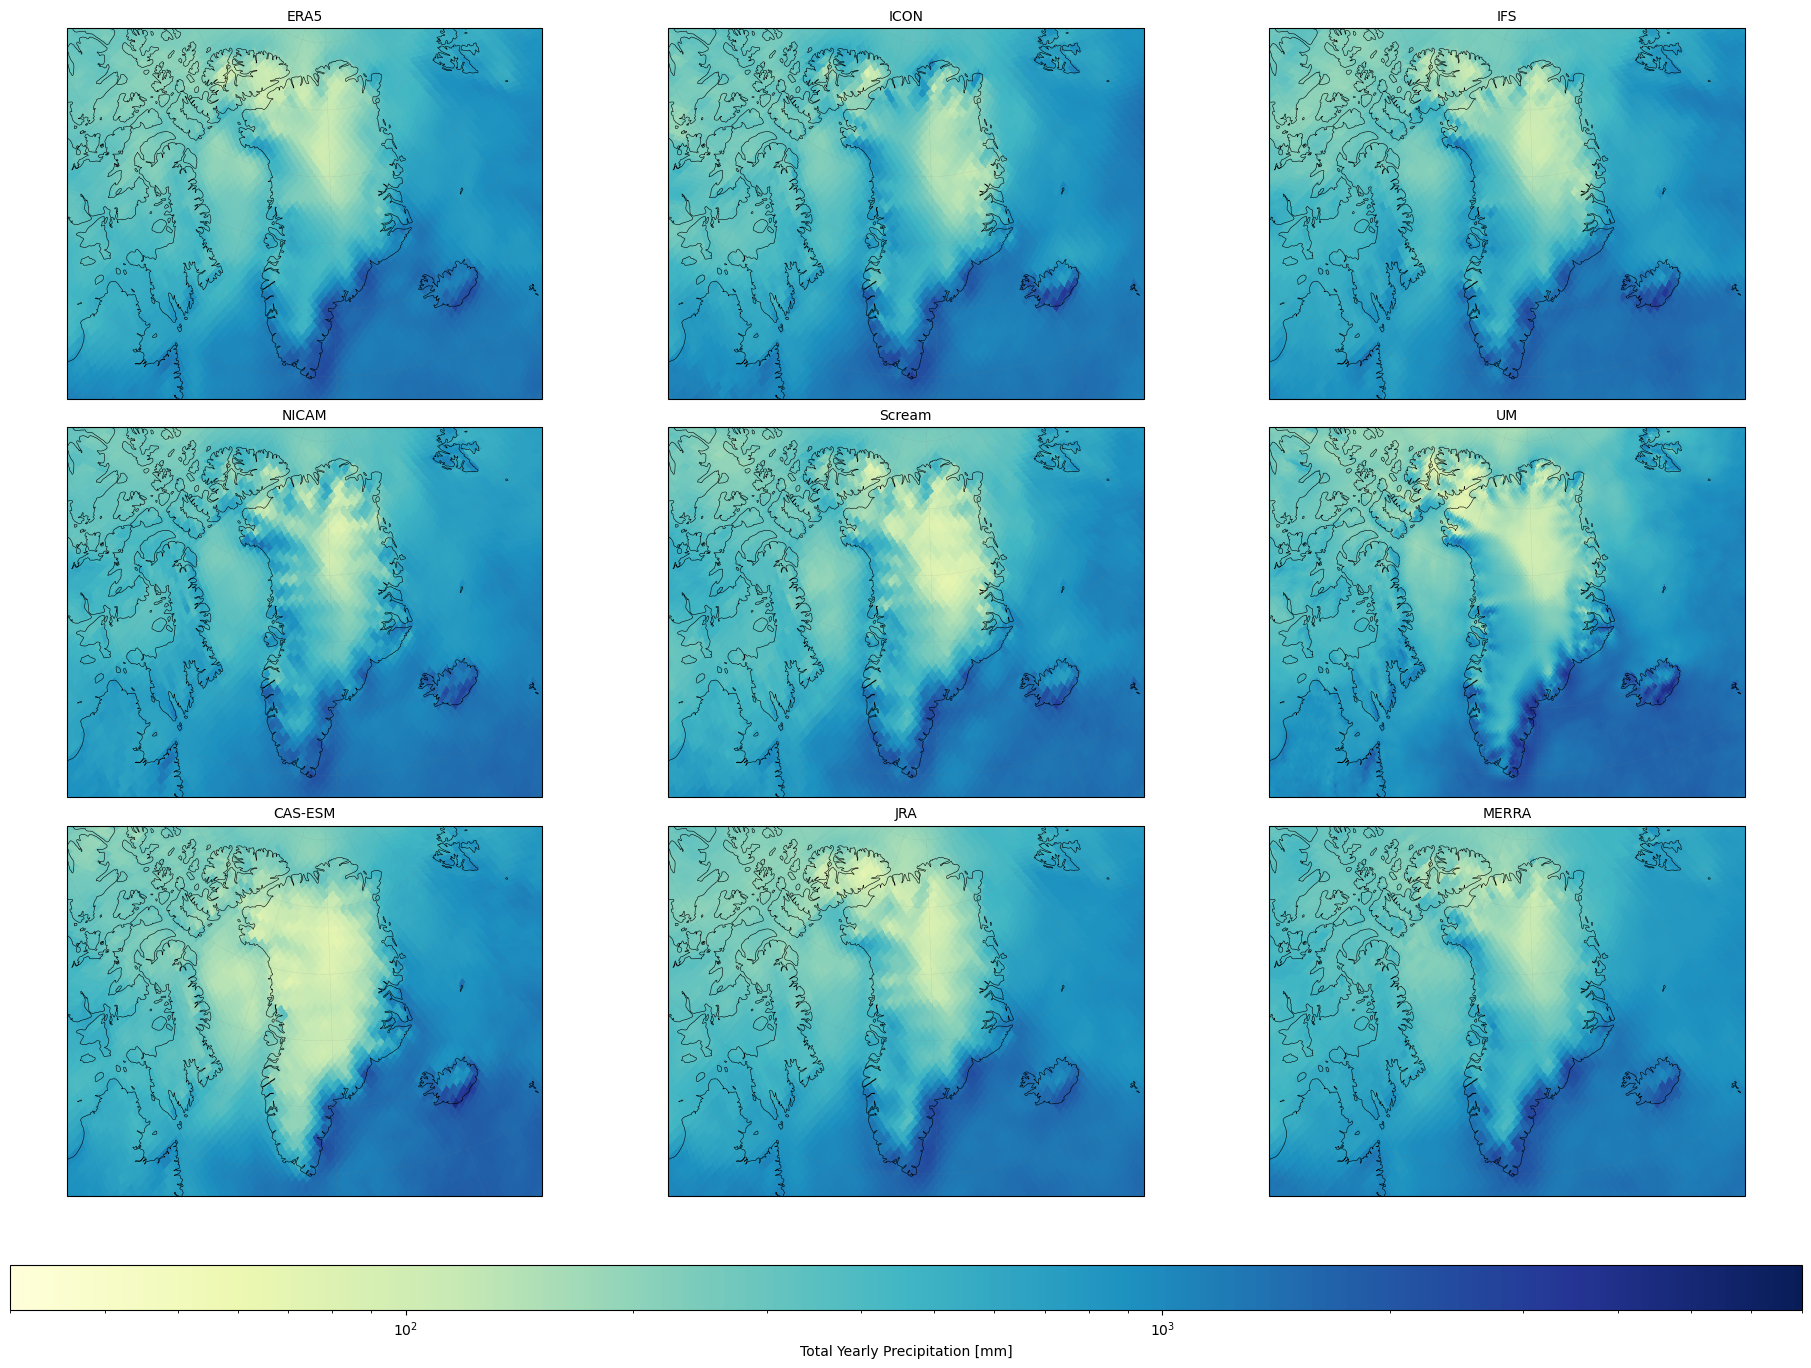

In [6]:
precip_map(region="greenland")

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 51 times more chunks
  return self.array[key]
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10

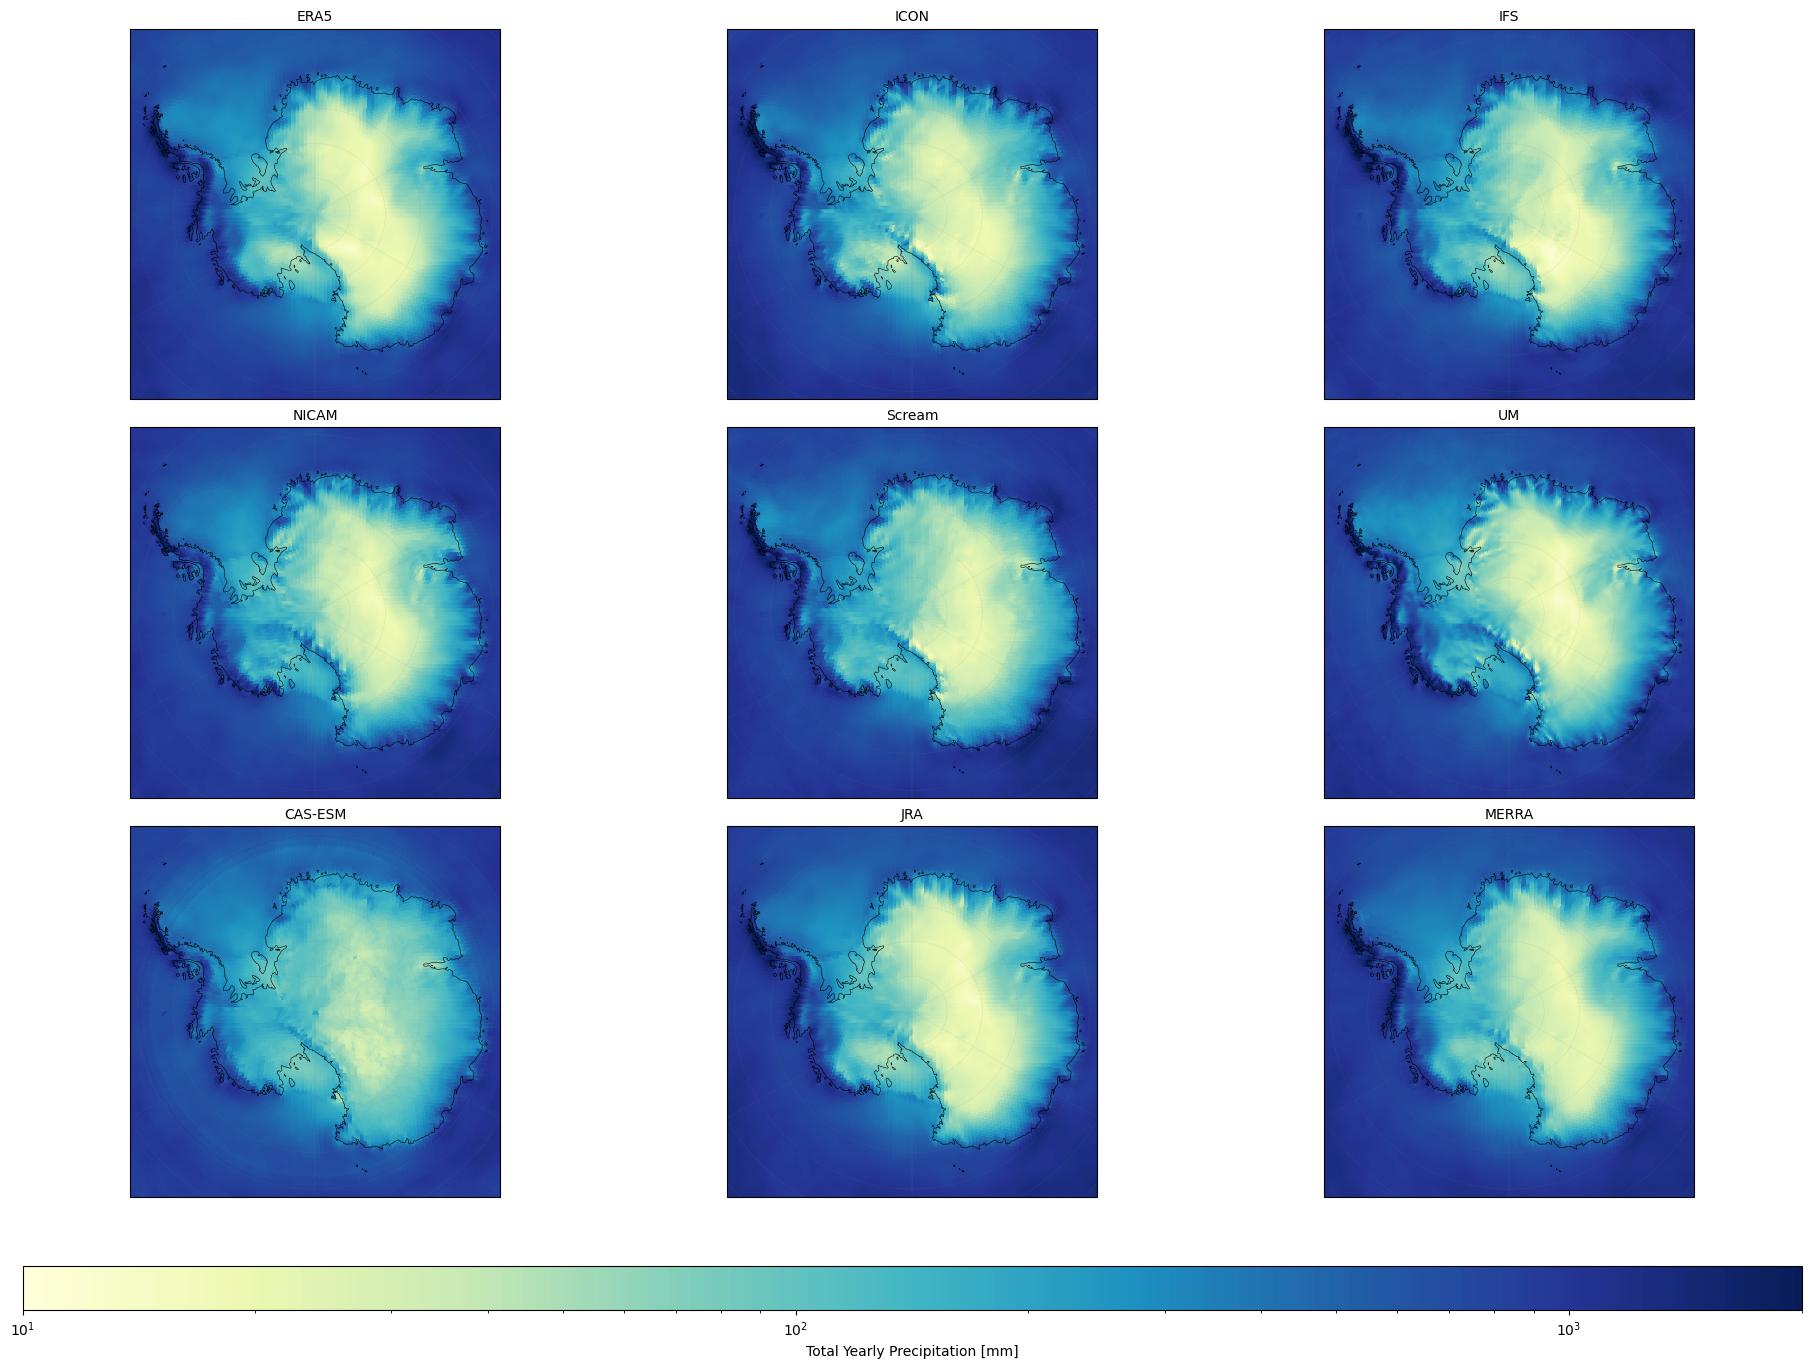

In [7]:
precip_map(region="Antarctica")